# Grouping audio by NoveltyCurve

In [146]:
%cd /Users/bastus/Desktop/Forschungsprojekt/genimpro

/Users/bastus/Desktop/Forschungsprojekt/genimpro


In [147]:
%run importwrapper.py
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Prepare test tracks

In [148]:
track = genimpro.recordings.getRecordingDetails(93,printDetails=1)[4][0]

93 (None):
    Marius Werner (snaredrum): 1/f199ef77-778a-4fa5-9326-f377388687a8.aiff
    Felix Bratfisch (snaredrum): 1/25a85c12-3e51-4aec-9e20-e4643d2dc31d.aiff


In [149]:
audio = genimpro.recordings.getAudioForTrack(track)
filename = track[2]

In [150]:
track2 = genimpro.recordings.getRecordingDetails(133,printDetails=1)[4][1]
audio2 = genimpro.recordings.getAudioForTrack(track2)

133 (import/0003 A B-1.aiff):
    Martin Weigert (recorder): 2/6c79816a-01ff-4742-8462-3ebba84b7eb8.aiff
    Caroline Hausen (recorder): 2/b264c1d3-1737-4df1-99c3-b62e27dfcbf7.aiff


### Grouping by adaptive silence regions

In [151]:
from essentia.standard import *

In [152]:
def noveltyCurveForAudio(audio,hopSize=1024,t_silence=0.04):
    
    loudness = essentia.standard.Loudness()
    w = essentia.standard.Windowing()
    spec = essentia.standard.Spectrum()
    bands = essentia.standard.FrequencyBands()
    mfcc = essentia.standard.MFCC()
    loudness = essentia.standard.Loudness()
    
    timestamps = len(audio)
    
    bands_energies = []
    mfccs = []
    silenceFrames = 0
    for frame in FrameGenerator(audio, frameSize = hopSize*2, hopSize = hopSize):
        spectrum = spec(w(frame))
        #mfccs.append(bands(spectrum))
        mfccs.append(mfcc(spectrum)[1])
        if loudness(frame) >= t_silence:
            silenceFrames+=1

    
    loudnessRatio =  float(silenceFrames) / len(mfccs)
    #print loudnessRatio
    
    frameRate = len(audio)/len(mfccs)
    
    noveltyCurve = essentia.standard.NoveltyCurve(frameRate=frameRate,weightCurveType='inverse_quadratic',normalize=True)(numpy.array(mfccs))
    shiftFrames = 50
    
    return (noveltyCurve[shiftFrames:],range(0,timestamps-hopSize*shiftFrames,hopSize),frameRate,loudnessRatio)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


2448


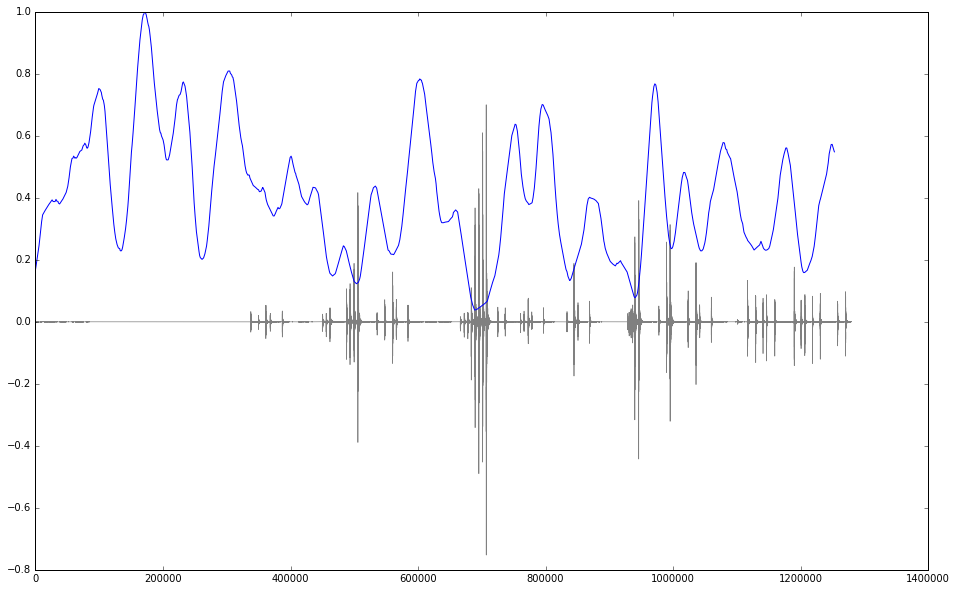

In [153]:
hopSize=1024/2
groupAudio = audio[3*samplerate:32*samplerate]
curve,feature_x,frameRate,loudnessRatio = noveltyCurveForAudio(groupAudio,hopSize=hopSize)

print len(curve)
plt.figure(figsize=(16, 10))
plt.plot(groupAudio,'0.5',label="Audio Waveform",linewidth=0.7)

plt.plot(feature_x,curve/curve.max())
wavPlayer(groupAudio,samplerate)

In [154]:
from scipy.signal import argrelextrema
boundaries = argrelextrema(curve, np.greater,order=int(20 + 100*loudnessRatio))[0]
print boundaries
print len(boundaries)

[ 194  334  453  595  783  850  943 1041 1177 1287 1469 1552 1697 1792 1897
 1985 2106 2299 2440]
19


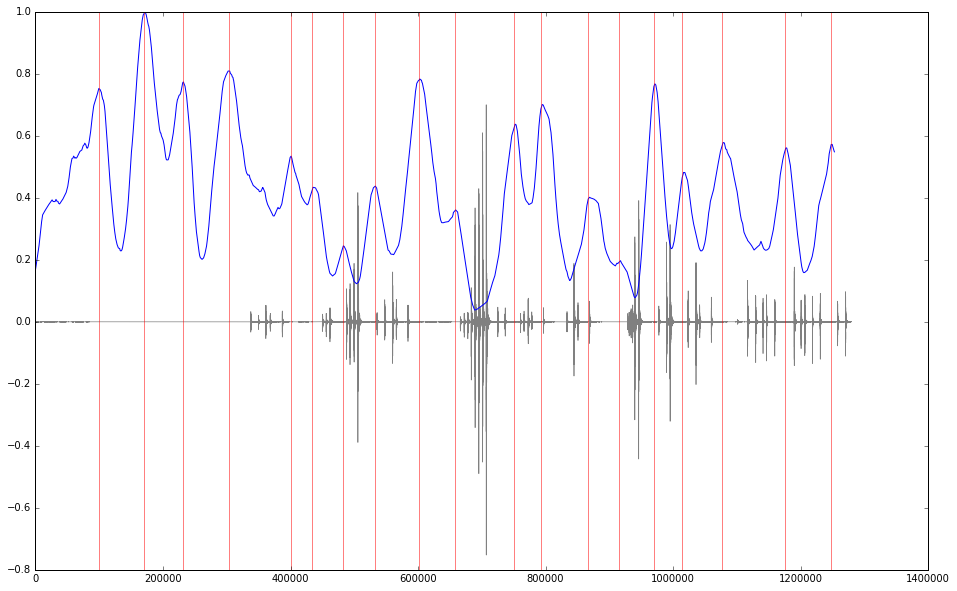

In [155]:
plt.figure(figsize=(16, 10))
plt.plot(groupAudio,'0.5',label="Audio Waveform",linewidth=0.7)

plt.plot(feature_x,curve/curve.max())

for j,boundary in enumerate(boundaries):
    #print boundary
    #plt.axvspan(boundaries[0]-start,boundaries[1]-start, color='g', alpha=0.3)
    plt.axvline(x=boundary*frameRate, linewidth=0.5,color='r')
    #plt.text(group[0]-start+0.05, 0.05,'%i'% (i+j+1),bbox=dict(boxstyle='round', facecolor='r', alpha=0.5),fontsize=14,horizontalalignment='left')
    

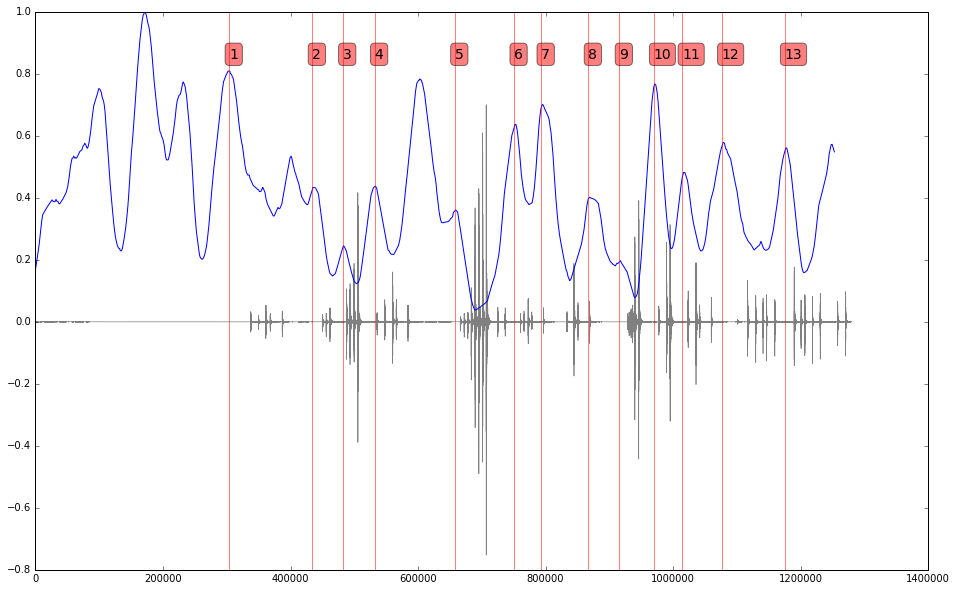

In [156]:
loudness = essentia.standard.Loudness()
sortedBoundaries = []
for i in range(len(boundaries)-1):
    if loudness(groupAudio[boundaries[i]*frameRate:boundaries[i+1]*frameRate]) >= 0.04:
        sortedBoundaries.append(boundaries[i])
    #else:
        #print i

plt.figure(figsize=(16, 10))
plt.plot(groupAudio,'0.5',label="Audio Waveform",linewidth=0.7)

plt.plot(feature_x,curve/curve.max())

for j,boundary in enumerate(sortedBoundaries):
    plt.axvline(x=boundary*frameRate, linewidth=0.5,color='r')
    plt.text(boundary*frameRate, 0.85,'%i'% (j+1),bbox=dict(boxstyle='round', facecolor='r', alpha=0.5),fontsize=14,horizontalalignment='left')
    

Convert to sample-based sound cells

In [179]:
soundcells = []
for i in range(len(sortedBoundaries)-1):
    soundcells.append([sortedBoundaries[i]*frameRate,sortedBoundaries[i+1]*frameRate])
soundcells.append([sortedBoundaries[-1]*frameRate,len(groupAudio)])

In [160]:
soundcells[0]

[304045, 434350]

Trim sound cells

In [180]:
t_silence=0.04
releaseFrames = 10
for i,soundcell in enumerate(soundcells):
    start = soundcell[0]
    end = soundcell[1]
    soundcellAudio = groupAudio[start:end]
    silenceFrames = []
    silenceFramesize = hopSize/2
    for frame in FrameGenerator(soundcellAudio, frameSize = silenceFramesize, hopSize = silenceFramesize):
        if loudness(frame) >= t_silence:
            silenceFrames.append(0)
        else:
            silenceFrames.append(1)
    
    sIdx = 0
    while (silenceFrames[sIdx]== 1 & (sIdx <len(silenceFrames)-1)):
        start+=silenceFramesize
        sIdx+=1

    eIdx = len(silenceFrames)-1
    while (cmp(silenceFrames[eIdx-releaseFrames:eIdx],list(1 for j in range(releaseFrames))) == 0  & (eIdx>releaseFrames)):
        end-=silenceFramesize
        eIdx-=1
        
    soundcells[i] = [start,end]

In [131]:
soundcells[0]

[337581, 434350]

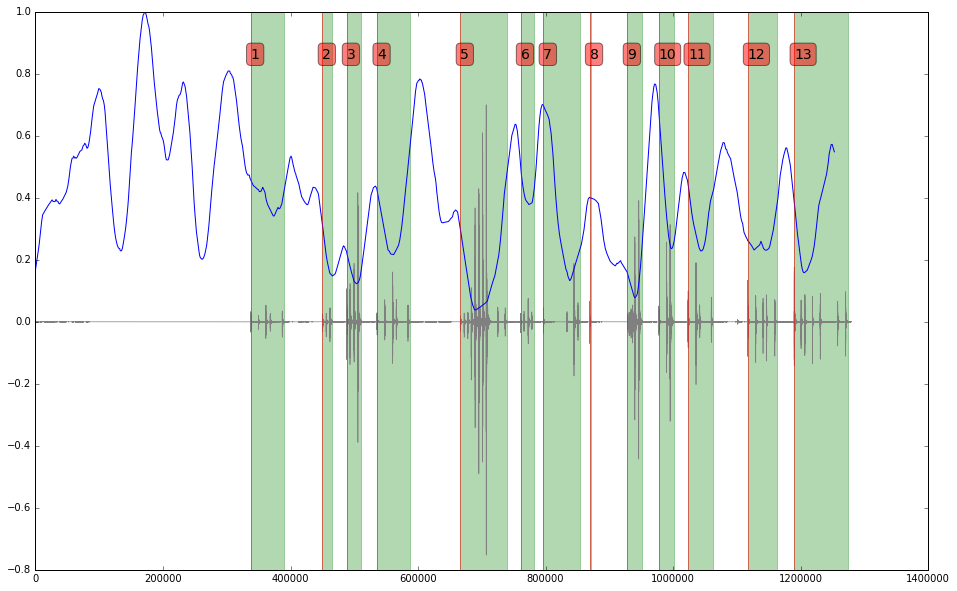

In [181]:
plt.figure(figsize=(16, 10))
plt.plot(groupAudio,'0.5',label="Audio Waveform",linewidth=0.7)

plt.plot(feature_x,curve/curve.max())

for j,soundcell in enumerate(soundcells):
    plt.axvspan(soundcell[0],soundcell[1], color='g', alpha=0.3)
    plt.axvline(x=soundcell[0], linewidth=0.5,color='r')
    plt.text(soundcell[0], 0.85,'%i'% (j+1),bbox=dict(boxstyle='round', facecolor='r', alpha=0.5),fontsize=14,horizontalalignment='left')
    

## The Group-by-Novelty alorithm

In [192]:
from scipy.signal import argrelextrema

def groupByNovelty(groupAudio,hopSize=1024/2,t_silence=0.03,orderBase=20,orderFactor=100,releaseFrames=10):

    curve,feature_x,frameRate,loudnessRatio = noveltyCurveForAudio(groupAudio,hopSize=hopSize)

    boundaries = argrelextrema(curve, np.greater,order=int(orderBase + orderFactor*loudnessRatio))[0]
    
    loudness = essentia.standard.Loudness()
    sortedBoundaries = []
    for i in range(len(boundaries)-1):
        if loudness(groupAudio[boundaries[i]*frameRate:boundaries[i+1]*frameRate]) >= 0.04:
            sortedBoundaries.append(boundaries[i])
    
    soundcells = []
    for i in range(len(sortedBoundaries)-1):
        soundcells.append([sortedBoundaries[i]*frameRate,sortedBoundaries[i+1]*frameRate])
    soundcells.append([sortedBoundaries[-1]*frameRate,len(groupAudio)])
    
    for i,soundcell in enumerate(soundcells):
        start = soundcell[0]
        end = soundcell[1]
        soundcellAudio = groupAudio[start:end]
        silenceFrames = []
        silenceFramesize = hopSize/2
        for frame in FrameGenerator(soundcellAudio, frameSize = silenceFramesize, hopSize = silenceFramesize):
            if loudness(frame) >= t_silence:
                silenceFrames.append(0)
            else:
                silenceFrames.append(1)

#        sIdx = 0
#        while (silenceFrames[sIdx]==1 & (sIdx <len(silenceFrames)-1)):
#            start+=silenceFramesize
#            sIdx+=1

#        eIdx = len(silenceFrames)-1
#        while (cmp(silenceFrames[eIdx-releaseFrames:eIdx],list(1 for j in range(releaseFrames))) == 0  & (eIdx>releaseFrames)):
#            end-=silenceFramesize
#            eIdx-=1

        soundcells[i] = [start,end]
        
    return soundcells

---
## Evaluation on Test Tracks

[[227395, 326529], [326529, 430262], [430262, 480851], [480851, 552902], [552902, 604002], [604002, 723065], [723065, 777231], [777231, 824243], [824243, 892206], [892206, 1020978], [1020978, 1062369], [1062369, 1106826], [1106826, 1174278], [1174278, 1302028], [1302028, 1383277], [1383277, 1415470], [1415470, 1490587], [1490587, 1551907], [1551907, 1621914], [1621914, 1673525], [1673525, 1726158], [1726158, 1799231], [1799231, 1898365], [1898365, 1946399], [1946399, 2044511], [2044511, 2097655], [2097655, 2152332], [2152332, 2199344], [2199344, 2256576], [2256576, 2312786], [2312786, 2383815], [2383815, 2430827], [2430827, 2489592], [2489592, 2544780], [2544780, 2600990], [2600990, 2654134], [2654134, 2770131], [2770131, 2816121], [2816121, 2858023], [2858023, 2899414], [2899414, 3028697], [3028697, 3107902], [3107902, 3209591], [3209591, 3325588], [3325588, 3422678], [3422678, 3478377], [3478377, 3550939], [3550939, 3605105], [3605105, 3700151], [3700151, 3820236], [3820236, 3869292]

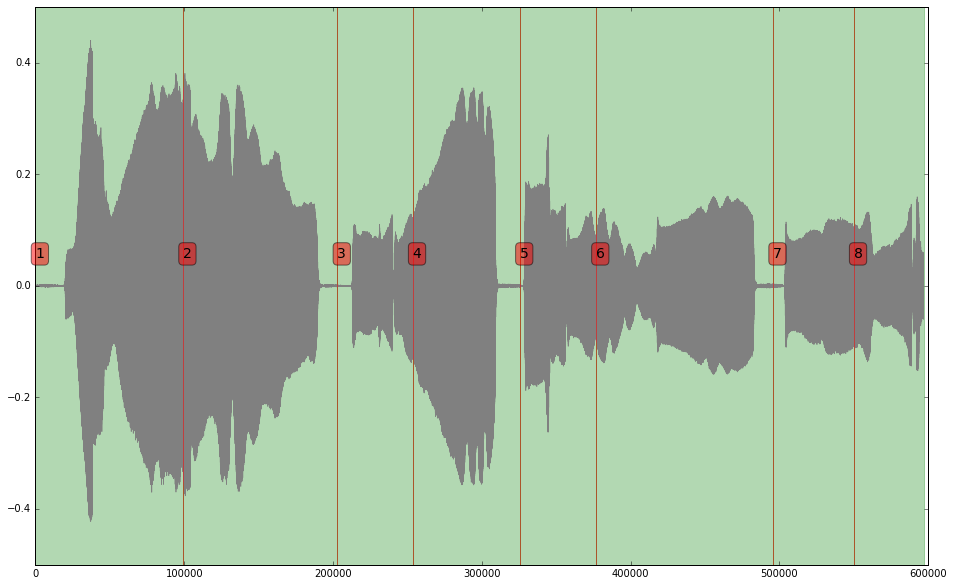

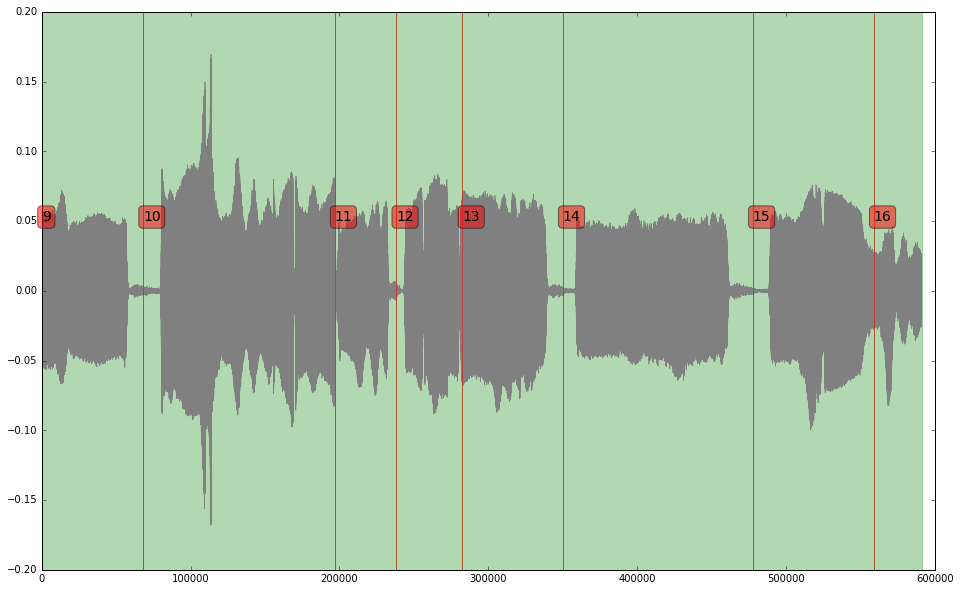

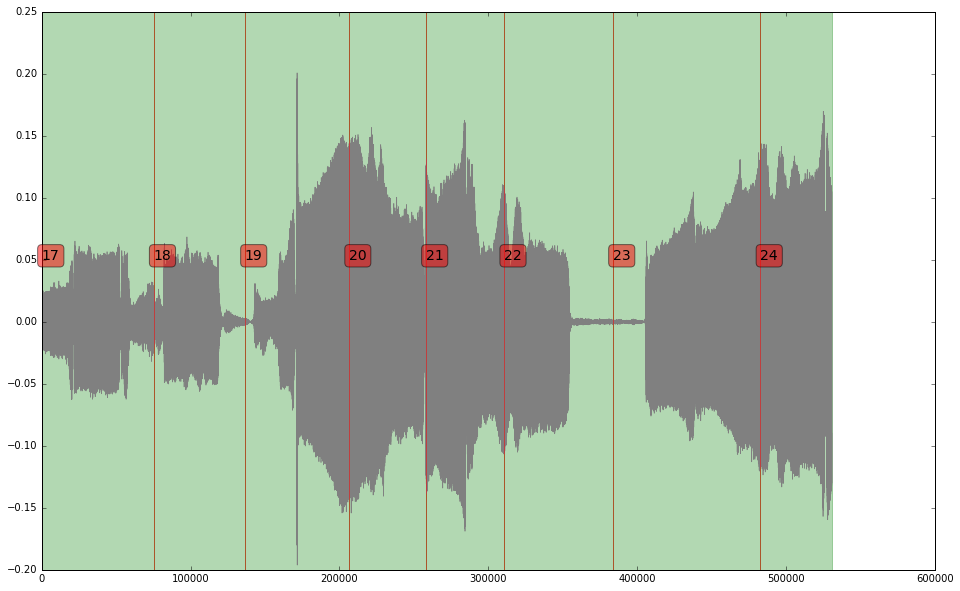

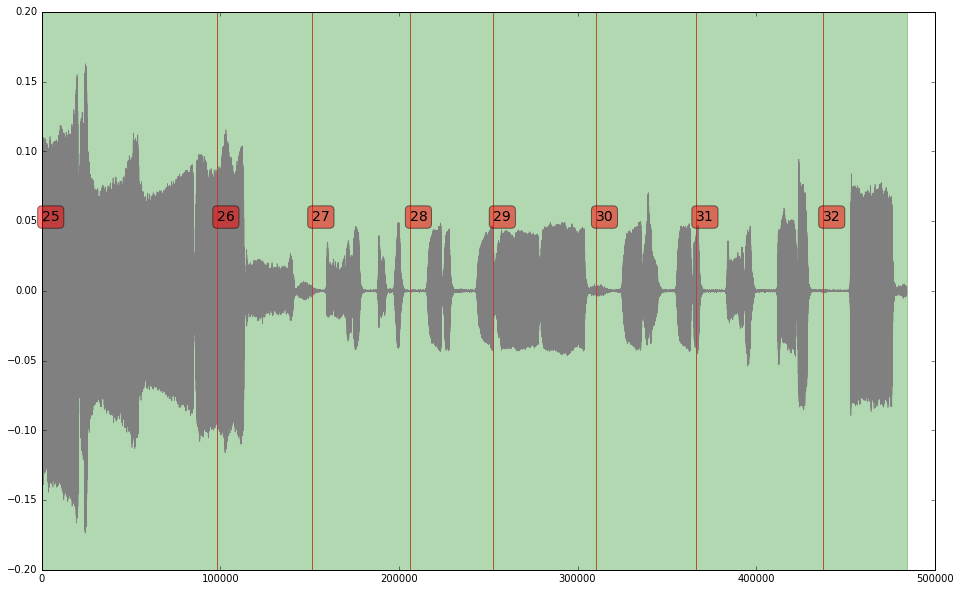

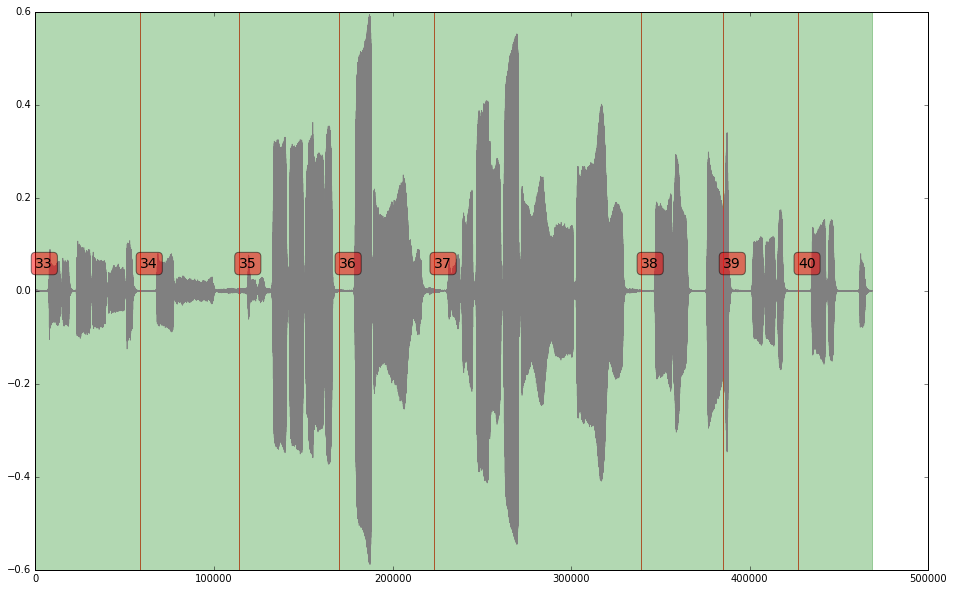

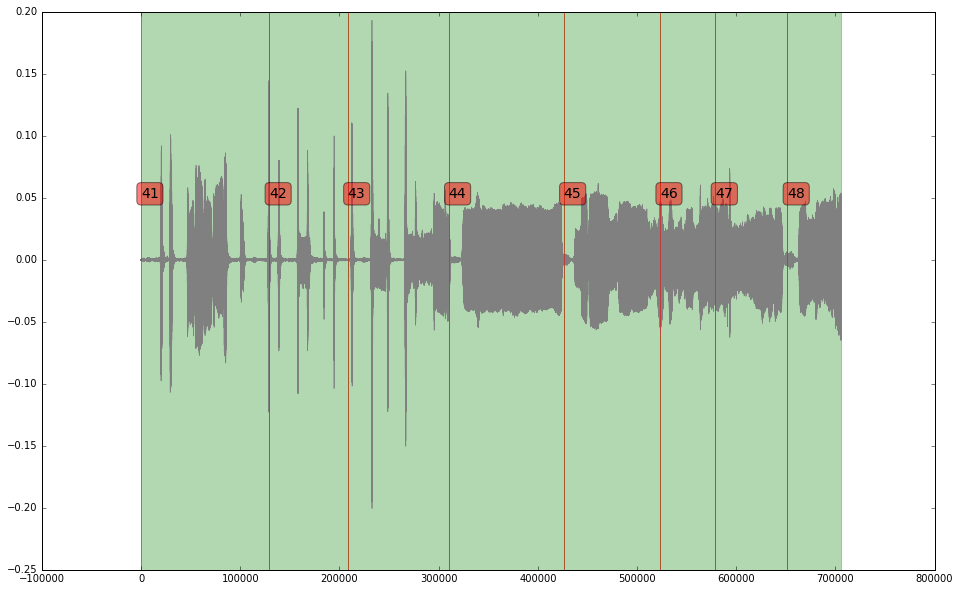

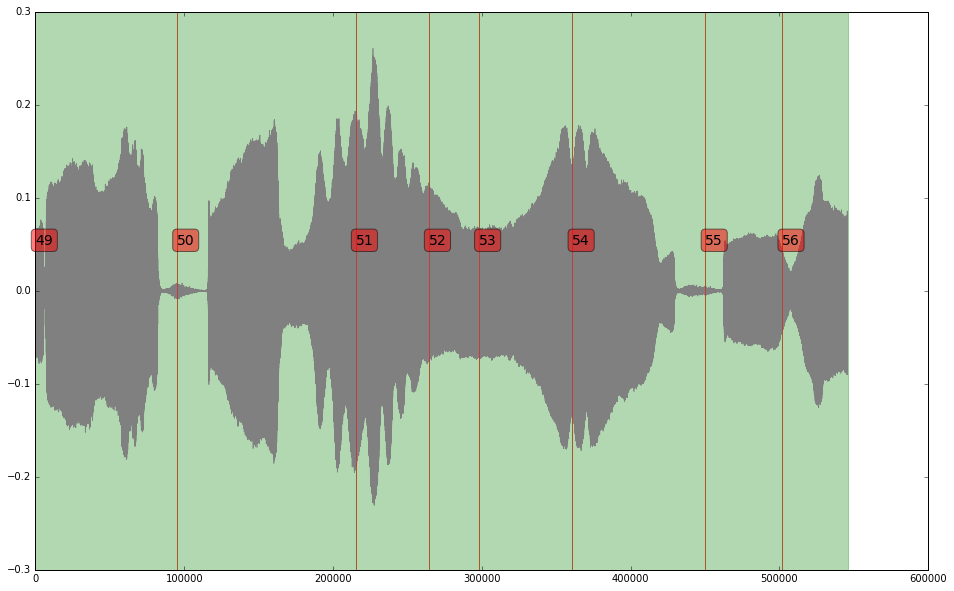

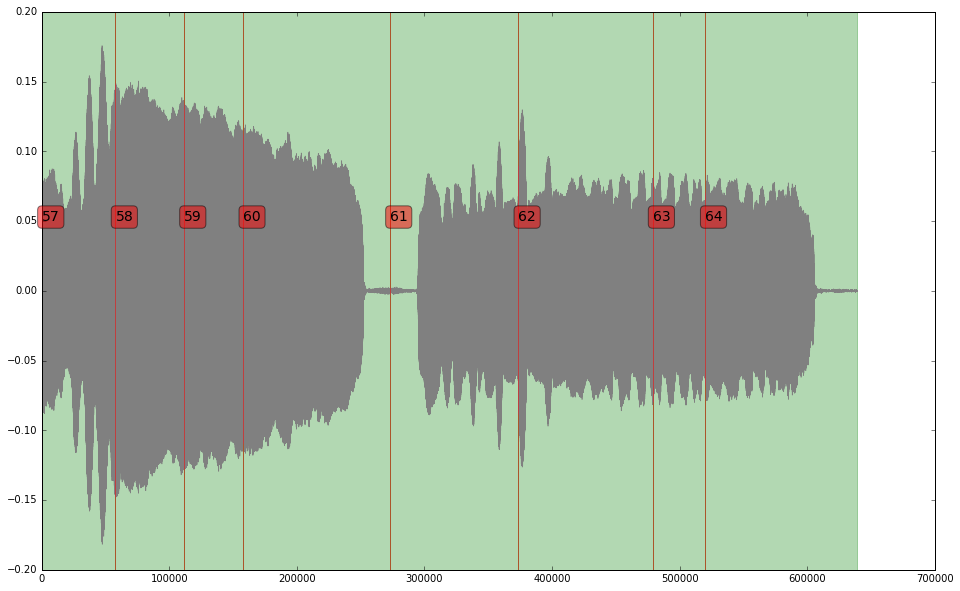

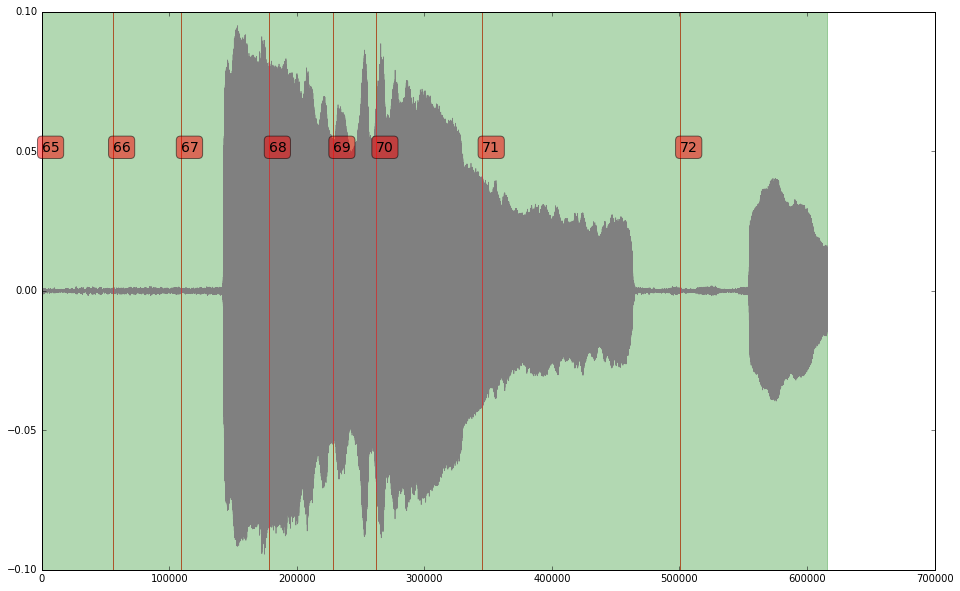

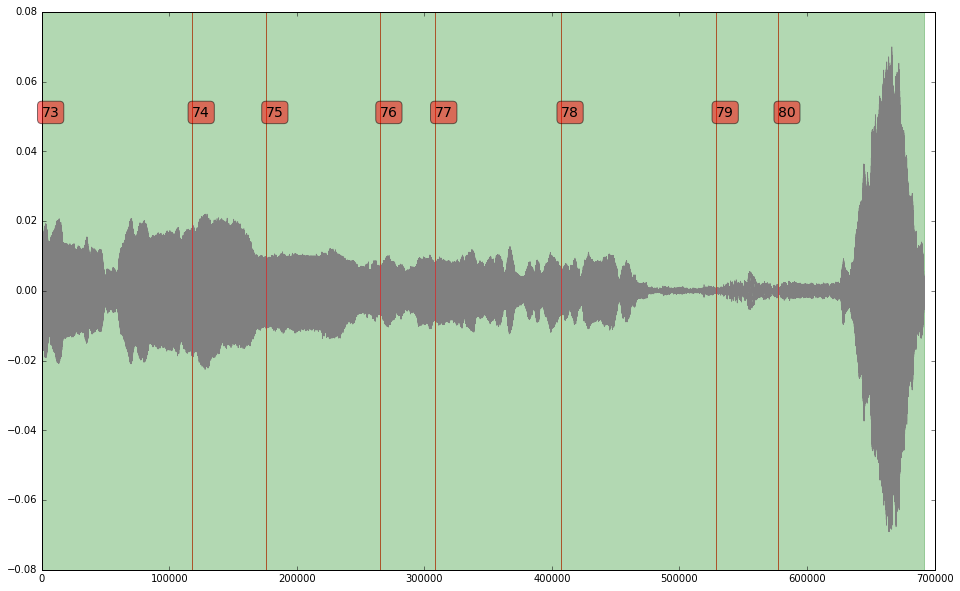

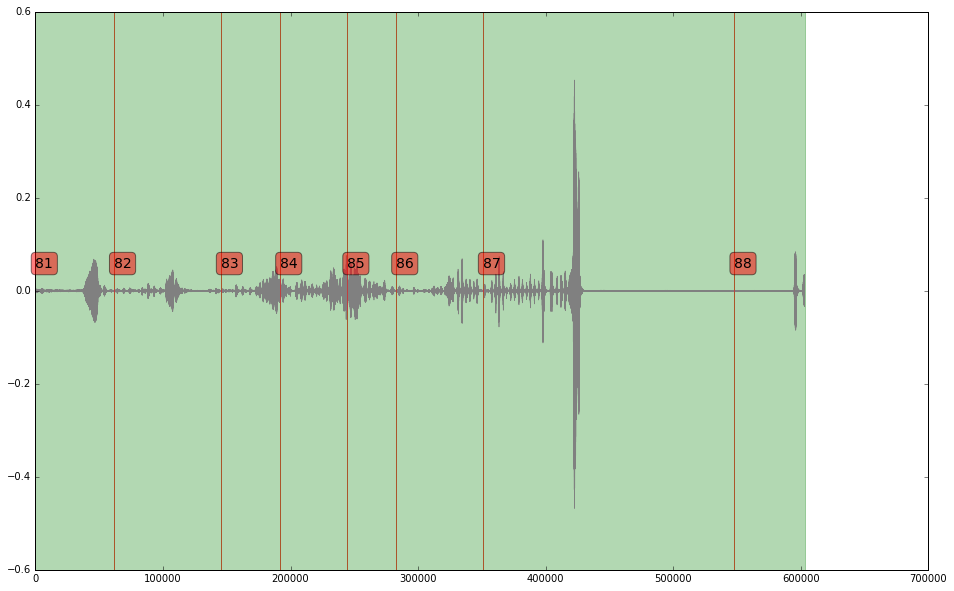

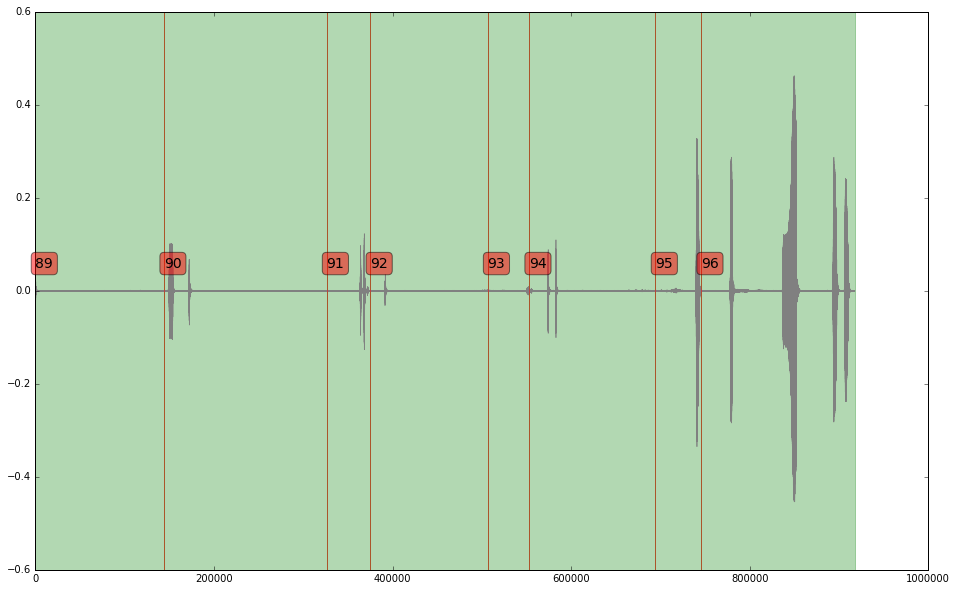

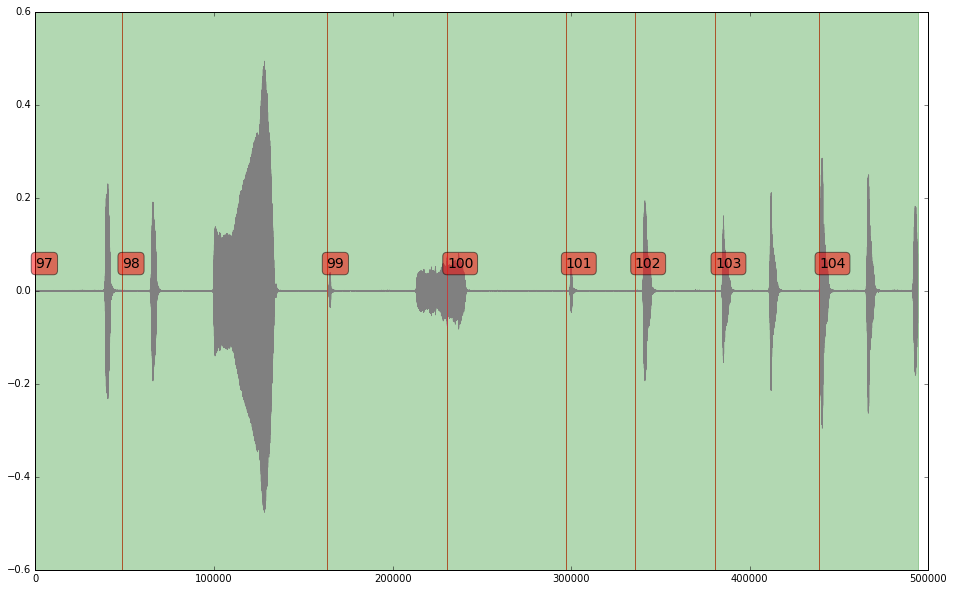

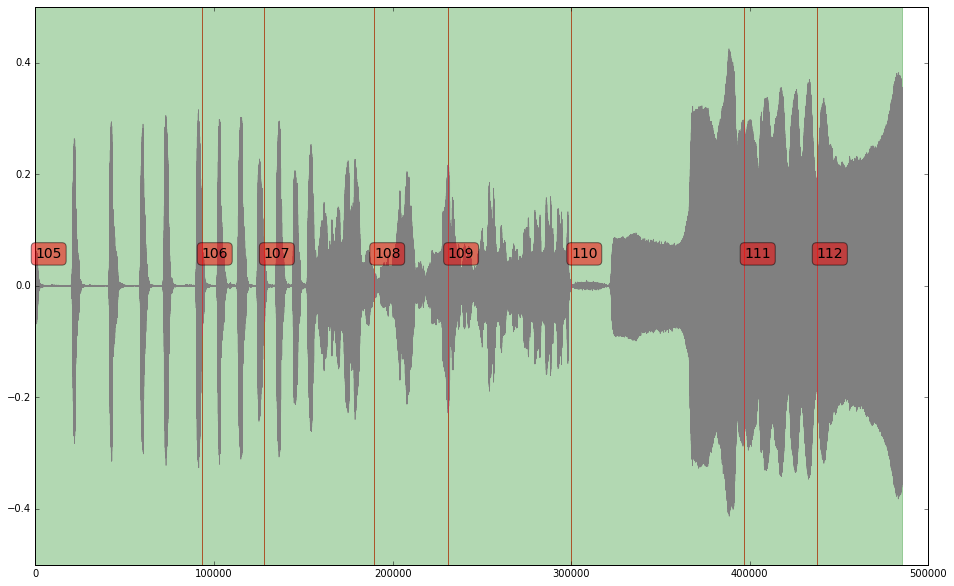

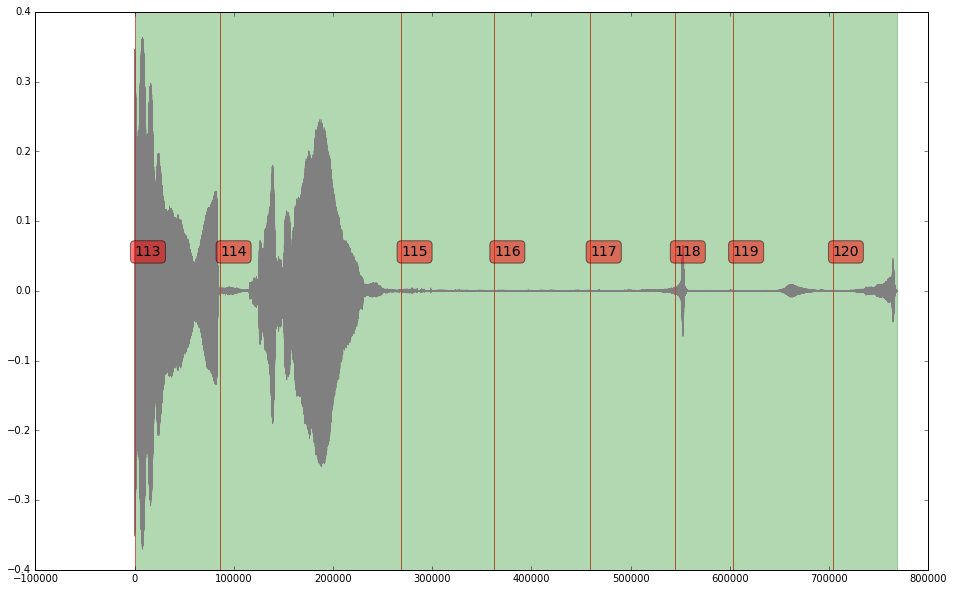

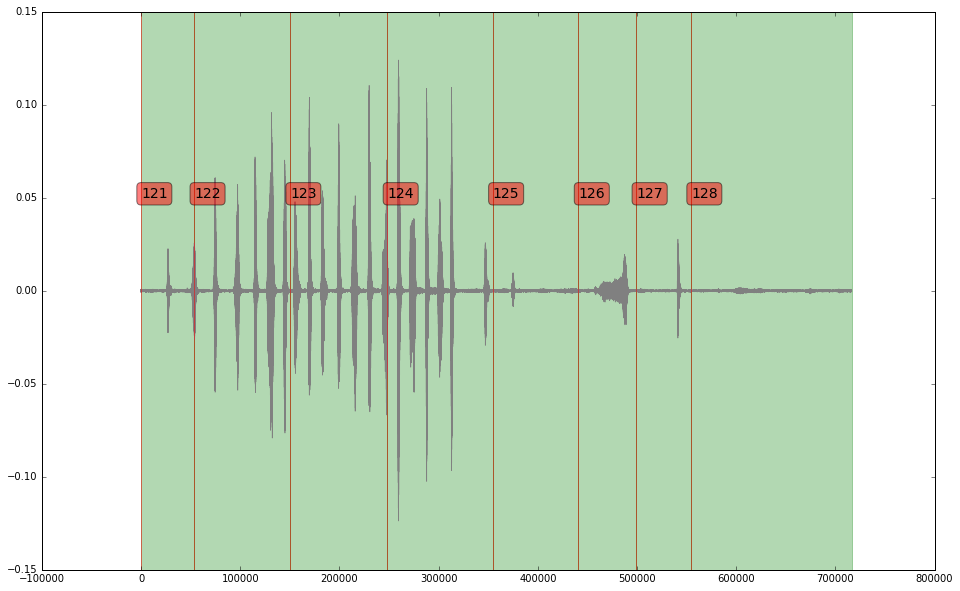

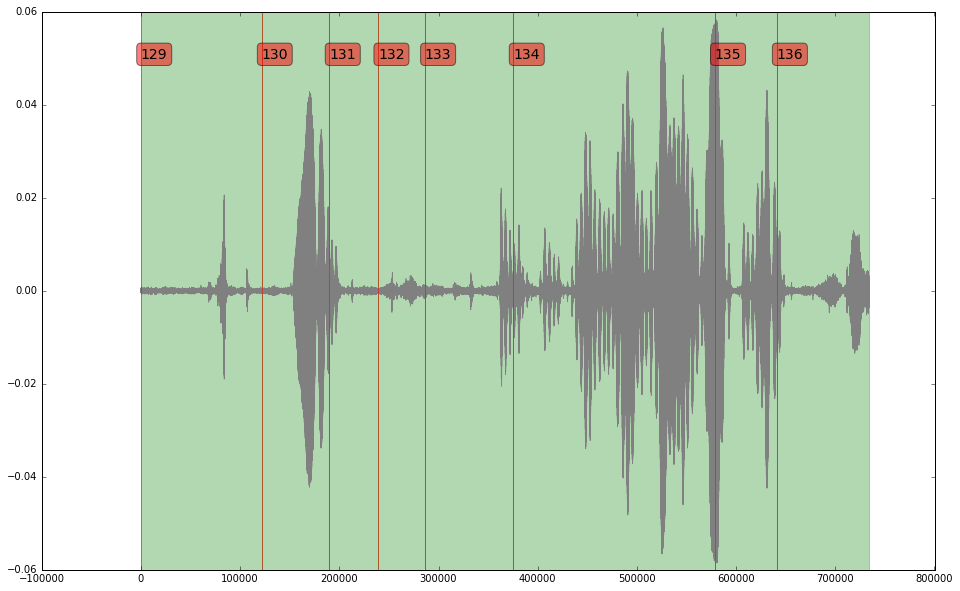

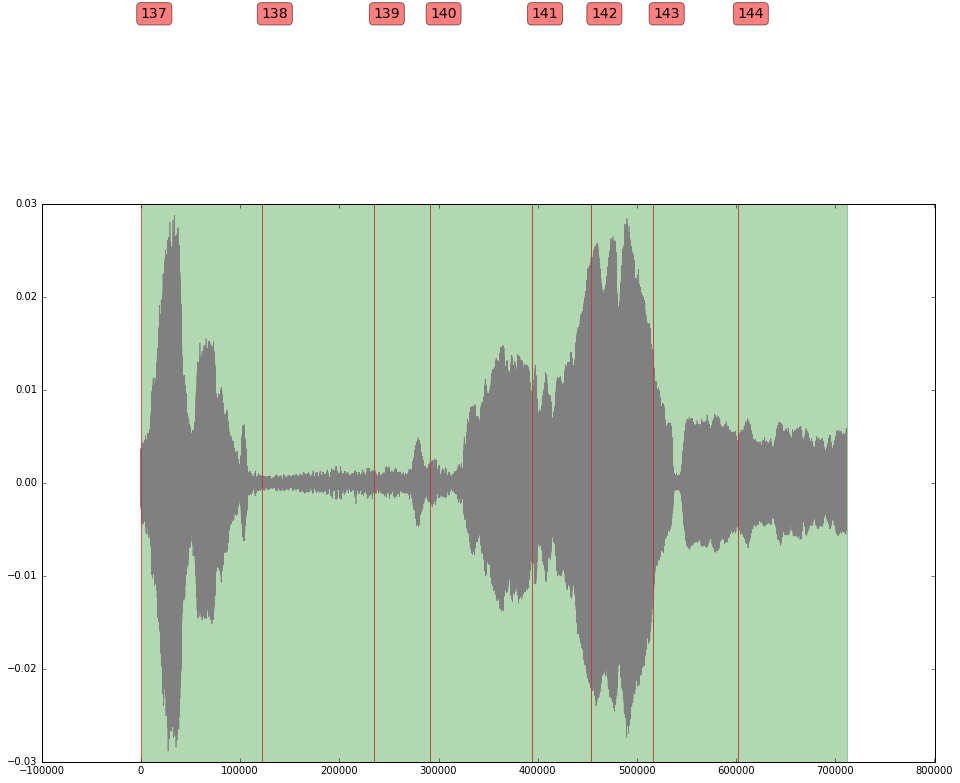

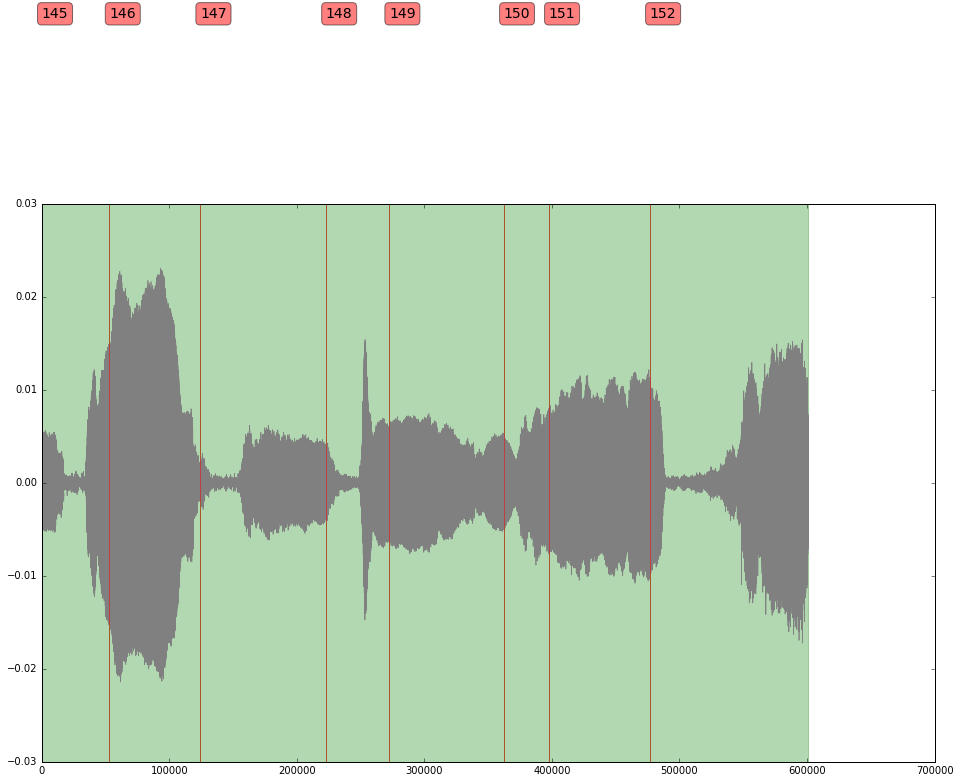

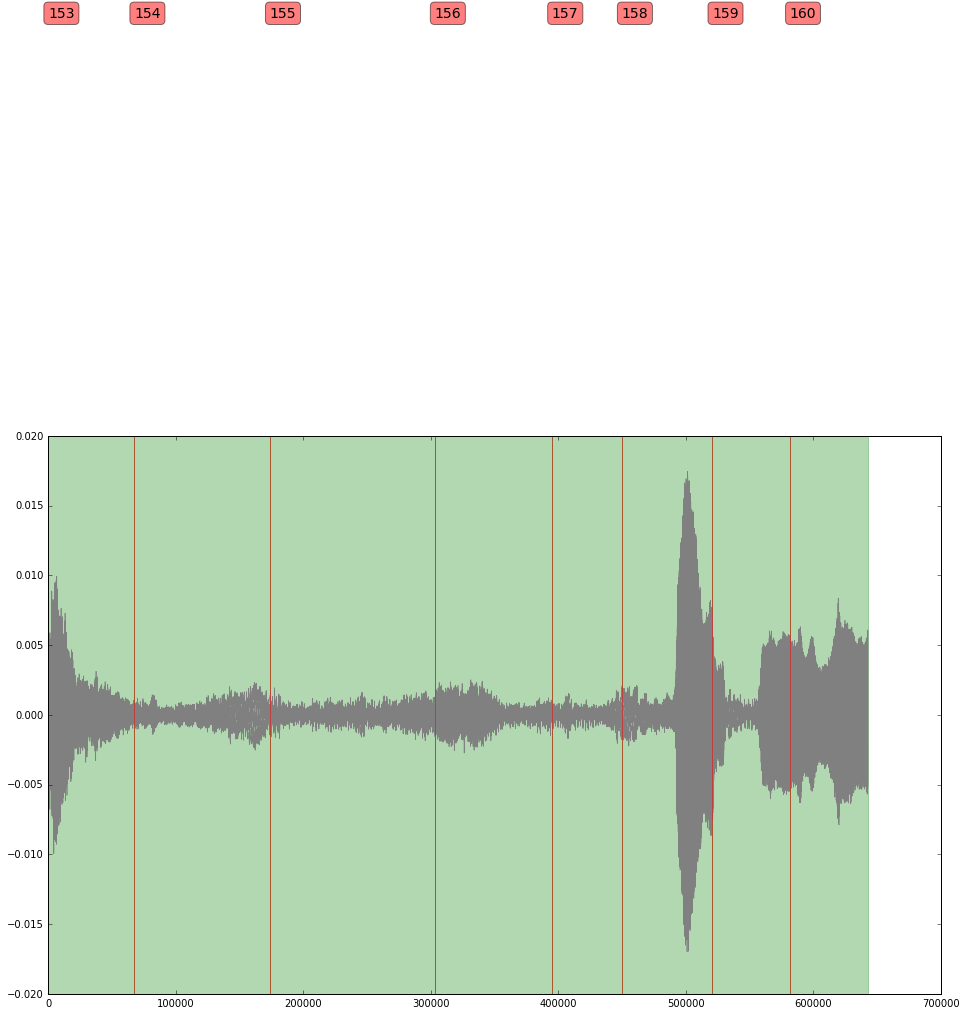

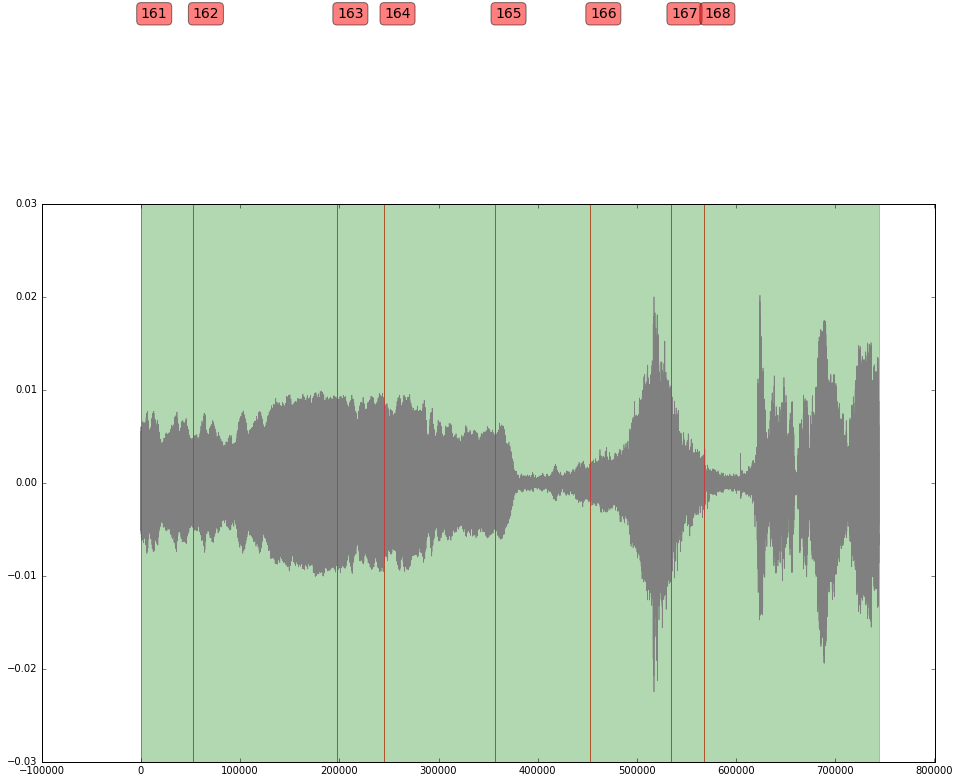

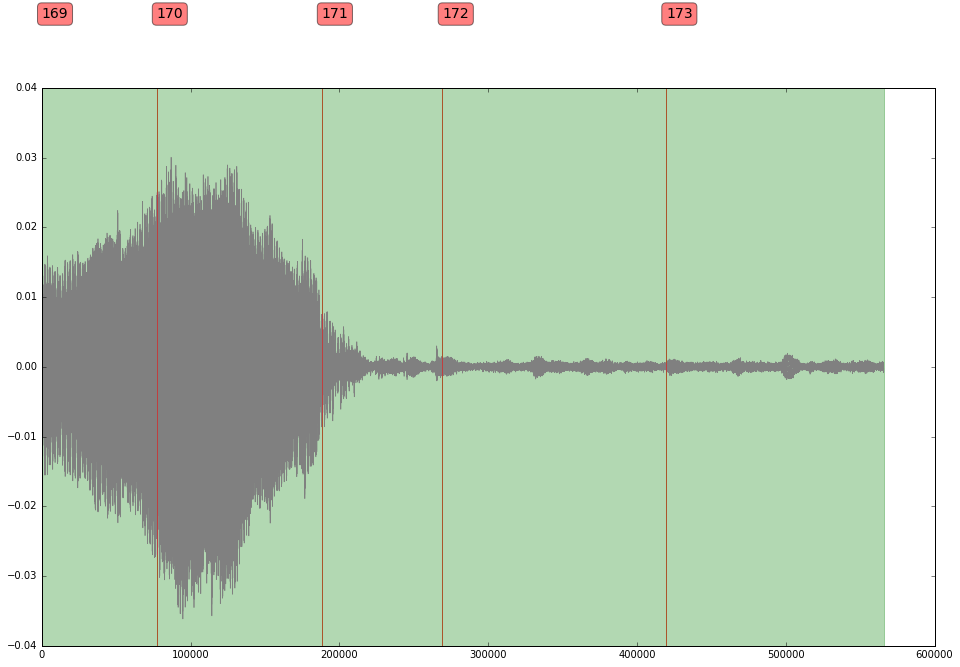

In [193]:
groups2 = groupByNovelty(audio2,orderBase=20,orderFactor=10)
print len(groups2)
#plotGroups(audio2,groups2)

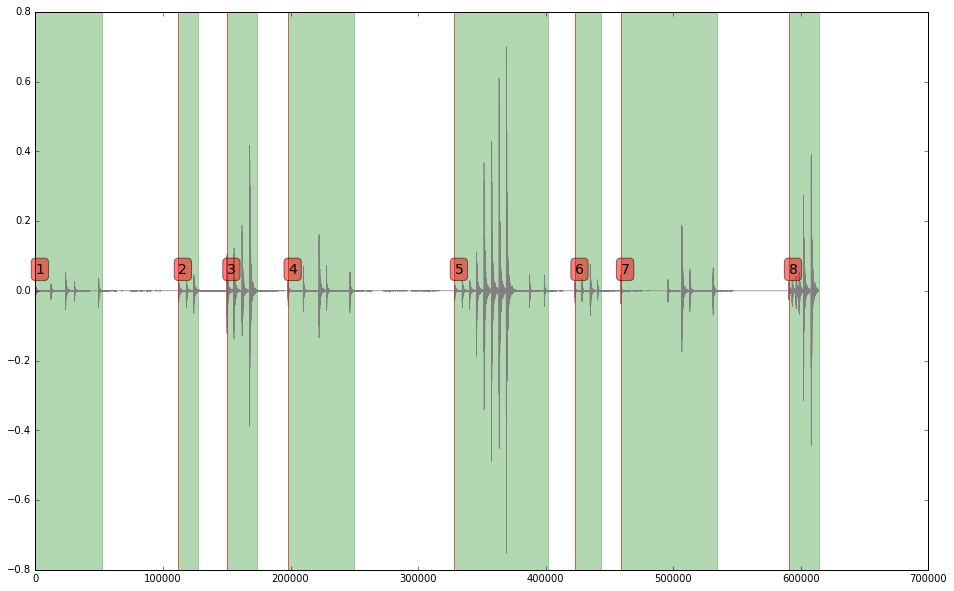

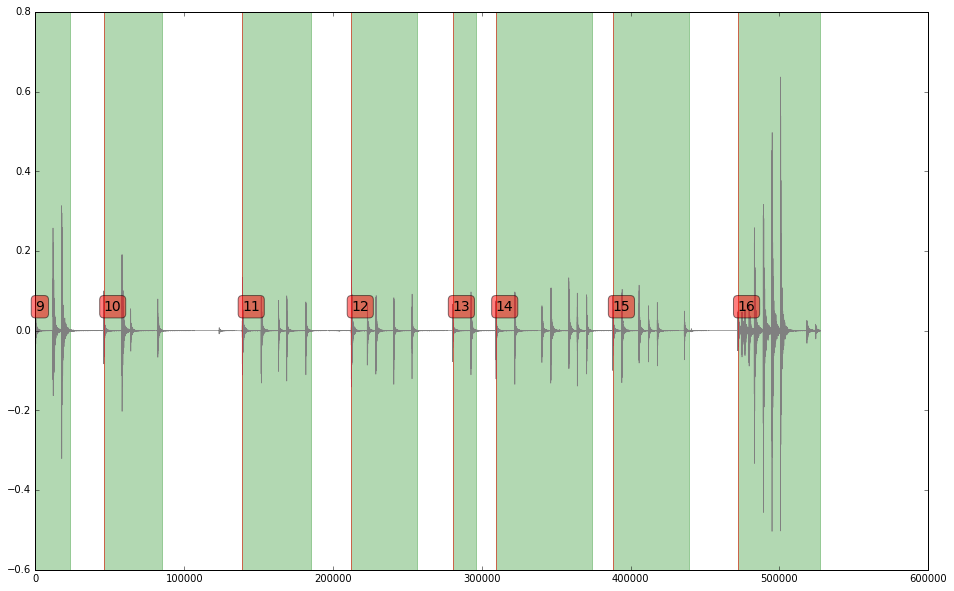

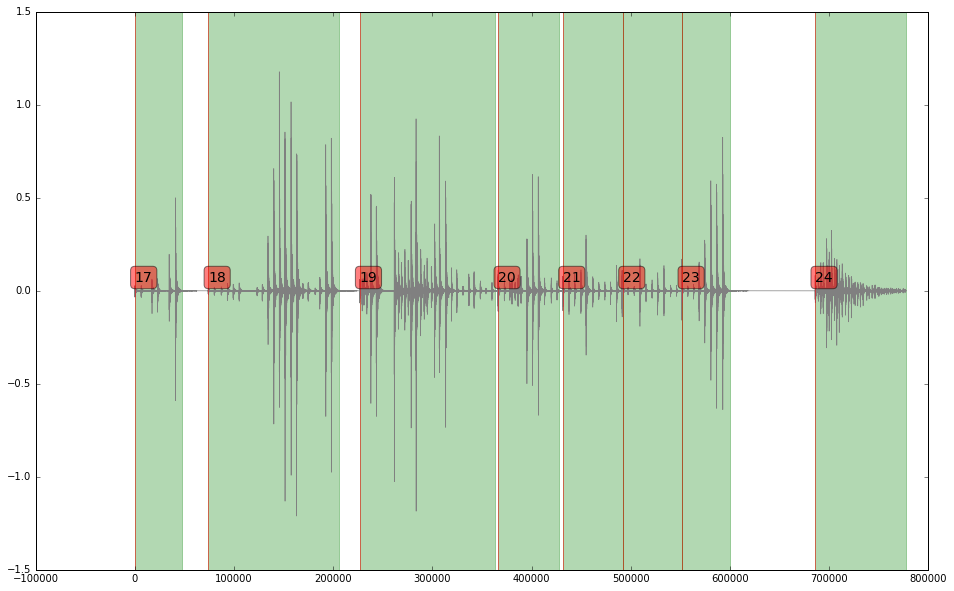

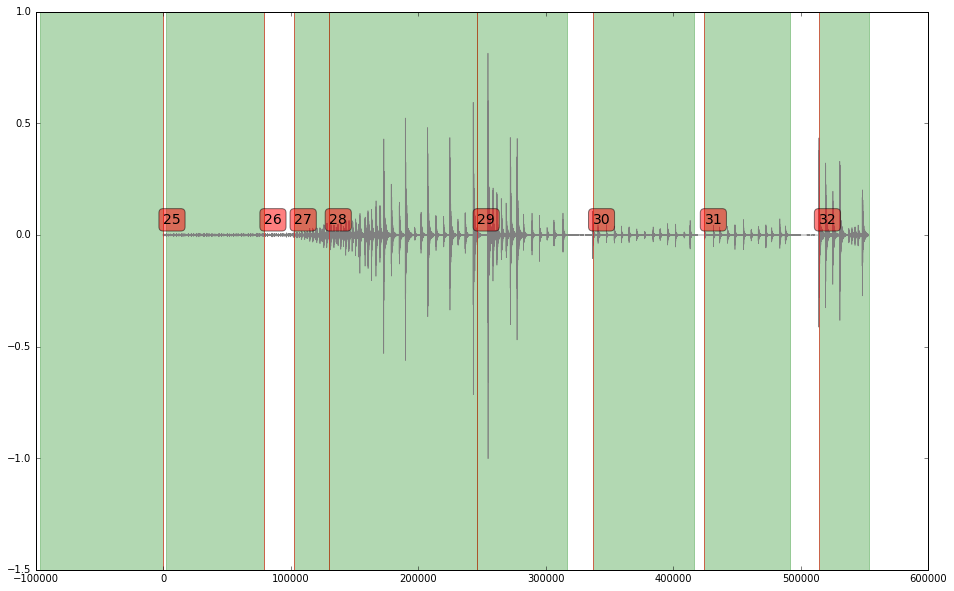

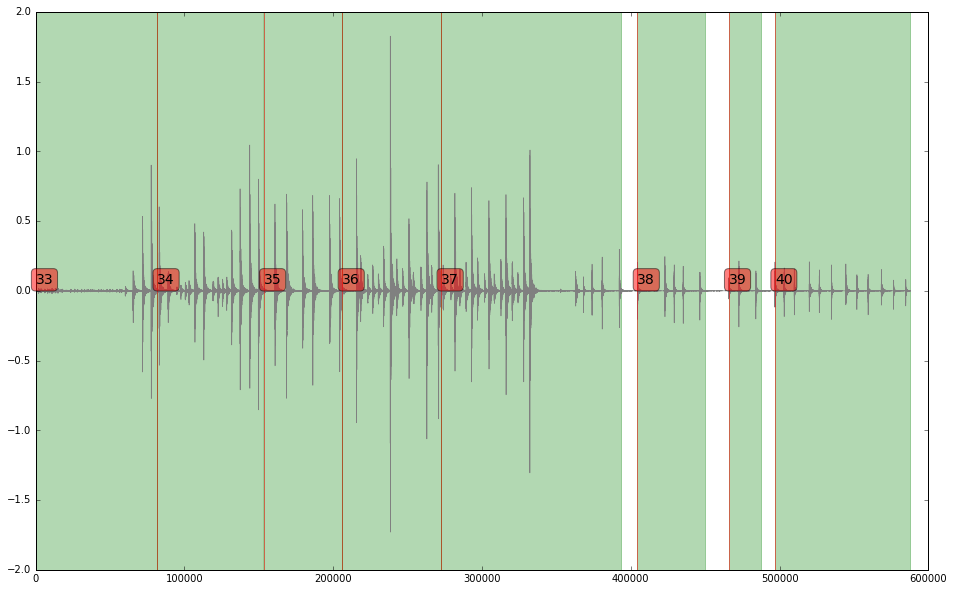

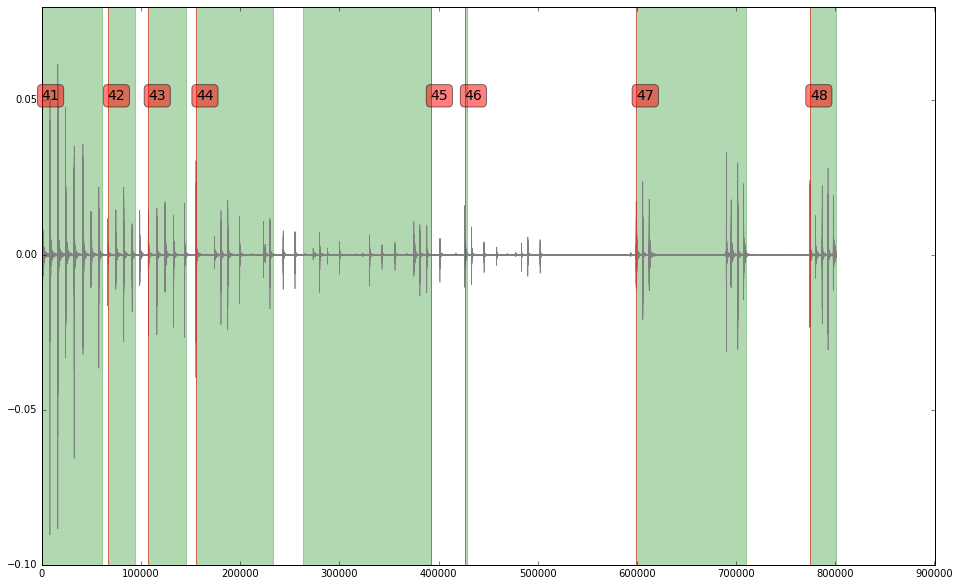

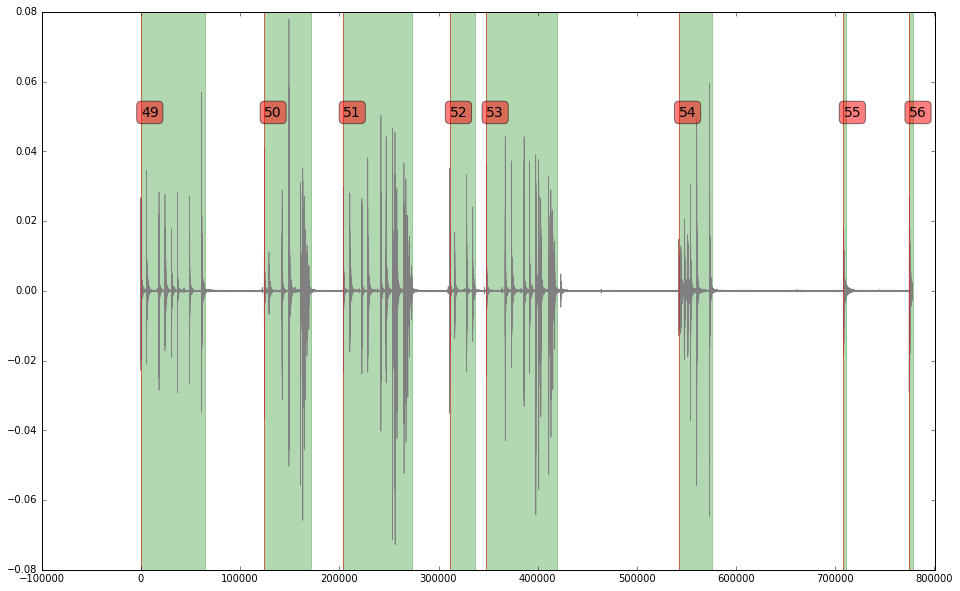

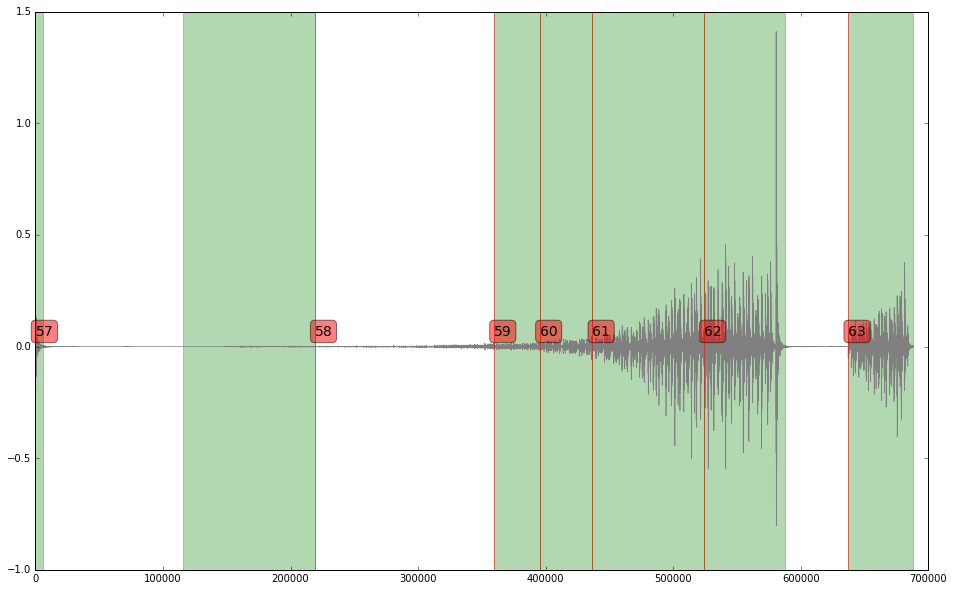

In [183]:
groups1 = groupByNovelty(audio)
plotGroups(audio,groups1)

In [184]:
pprint(groups1)

[[469943, 522415],
 [582063, 597580],
 [620108, 643560],
 [668136, 719617],
 [798465, 872006],
 [892998, 913389],
 [928749, 1004613],
 [1060421, 1084053],
 [1109909, 1133372],
 [1155900, 1195206],
 [1248966, 1295107],
 [1322243, 1366138],
 [1390202, 1406002],
 [1419314, 1483673],
 [1497753, 1549073],
 [1581841, 1637235],
 [1645427, 1693163],
 [1719531, 1850811],
 [1872059, 2008481],
 [2011809, 2072616],
 [2076968, 2137513],
 [2137513, 2197300],
 [2197300, 2245020],
 [2331292, 2422764],
 [2594796, 2498090],
 [2673962, 2597263],
 [2697615, 2725163],
 [2725163, 2841160],
 [2841160, 2911659],
 [2931627, 3010812],
 [3019260, 3086168],
 [3108696, 3147993],
 [3168473, 3249960],
 [3250216, 3321500],
 [3321756, 3374644],
 [3374644, 3441074],
 [3441074, 3562181],
 [3572933, 3618378],
 [3634250, 3655947],
 [3665419, 3756352],
 [3760960, 3821247],
 [3827391, 3854706],
 [3868530, 3906595],
 [3916579, 3993666],
 [4152898, 4023873],
 [4187201, 4189655],
 [4360407, 4471167],
 [4535423, 4561627],
 [462

---
#### Helper Functions

In [77]:
def plotGroups(audio,groups,hopSize=1024):
    
    for i in xrange(0, len(groups), 8):
        plt.figure(figsize=(16, 10))
        
        subgroups = groups[i:i+8]
        start = subgroups[0][0]
        end = subgroups[-1][1]
        
    
        plt.plot(audio[start:end],'0.5',label="Audio Waveform",linewidth=0.7)
            
        for j,group in enumerate(subgroups):
            plt.axvspan(group[0]-start,group[1]-start, color='g', alpha=0.3)
            plt.axvline(x=group[0]-start,linewidth=0.5,color='r')
            plt.text(group[0]-start+0.05, 0.05,'%i'% (i+j+1),bbox=dict(boxstyle='round', \
                facecolor='r', alpha=0.5),fontsize=14,horizontalalignment='left')
            
        plt.show()
        wavPlayer(audio[start:end],samplerate)